#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [57]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from sklearn.ensemble import RandomForestRegressor

In [58]:
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [59]:
display(df.head(10))
display(df.info())
df.shape

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None

(26496, 1)

In [60]:
# проверим в хронологическом ли порядке расположены даты и время
df.index.is_monotonic

True

In [61]:
df = df.resample('1H').sum()


In [62]:
df.head(5)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


### Вывод:

Загрузил данные, проверим в хронологическом ли порядке расположены даты и время, провел ресемплирование по 1 часу

## Анализ

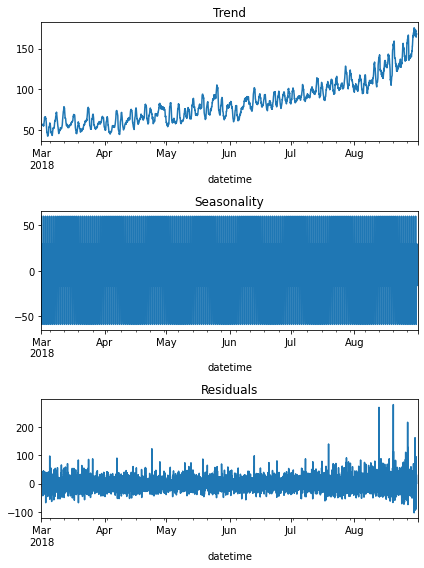

In [63]:
# проанализируем весь период
decomposed = seasonal_decompose(df)
plt.figure(figsize=(6, 8))
plt.subplot(311)
# Чтобы график корректно отобразился, указываем его
# оси ax, равными plt.gca() (англ. get current axis,
# получить текущие оси)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

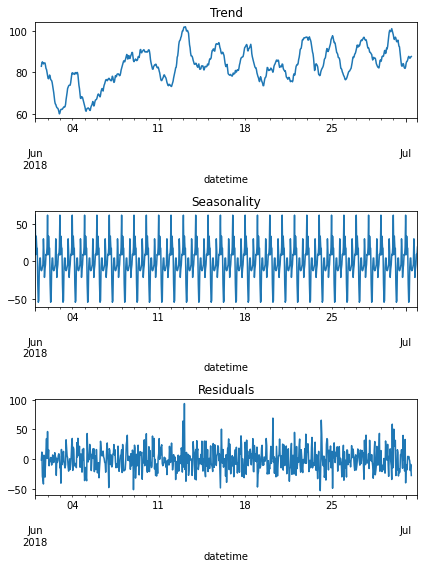

In [64]:
# проанализируем период в 1 месяц
decomposed = seasonal_decompose(df['2018-06-01':'2018-07-01'])
plt.figure(figsize=(6, 8))
plt.subplot(311)
# Чтобы график корректно отобразился, указываем его
# оси ax, равными plt.gca() (англ. get current axis,
# получить текущие оси)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

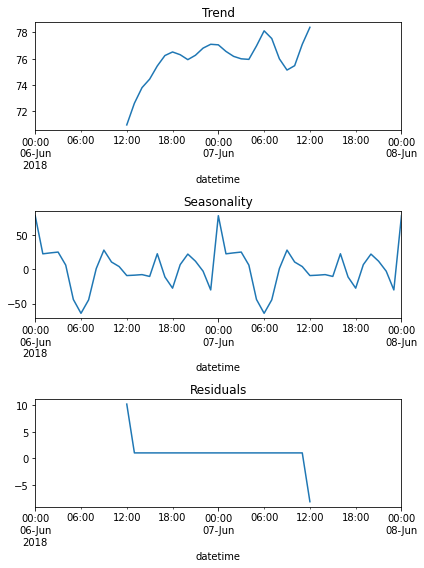

In [65]:
# проанализируем период за  2 дня
decomposed = seasonal_decompose(df['2018-06-06 00:00:00':'2018-06-08 00:00:00'])
plt.figure(figsize=(6, 8))
plt.subplot(311)
# Чтобы график корректно отобразился, указываем его
# оси ax, равными plt.gca() (англ. get current axis,
# получить текущие оси)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

### Вывод:

После анализа видно общий тренд на постоянное увеличение заказов

## Обучение

In [66]:
# напишем функцию созданияпризнаки
def make_features(df, max_lag, rolling_mean_size):
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()


#make_features(df, 2, 4)

In [67]:
best_rmse = 1000
best_lag = 0
best_rol = 0

for lag in range(1, 2):
    for rol in range(24, 100):
        make_features(df, lag, rol)
        
        train, test = train_test_split(df, shuffle=False, test_size=0.1)
        train = train.dropna()
        train_futures = train.drop('num_orders', axis=1)
        train_target = train['num_orders']
               
        model = LinearRegression()
        model.fit(train_futures, train_target)
        predicted_train = model.predict(train_futures)
        rmse = mean_squared_error(train_target, predicted_train)**0.5
        if rmse < best_rmse:
            best_rmse = rmse
            best_lag = lag
            best_rol = rol

print("Лучший RMSE LinearRegression на обучающей выборки:", best_rmse)
print("Лучший max_lag:", best_lag)
print("Лучший rolling_mean_size:", best_rol)



Лучший RMSE LinearRegression на обучающей выборки: 30.772393494452967
Лучший max_lag: 1
Лучший rolling_mean_size: 73


In [70]:
best_rmse = 1000
best_lag = 0
best_rol = 0

for lag in range(1, 2):
    for rol in range(24, 100):
        make_features(df, lag, rol)
        
        train, test = train_test_split(df, shuffle=False, test_size=0.1)
        train = train.dropna()
        train_futures = train.drop('num_orders', axis=1)
        train_target = train['num_orders']
               
       # model = DecisionTreeRegressor(random_state=12345, max_depth=i) # ВОТ ТУТ ОПИСКА У ТЕБЯ
        model = DecisionTreeRegressor(random_state=12345, max_depth=5)
        model.fit(train_futures, train_target)
        predicted_train = model.predict(train_futures)
      #  rmse = mean_squared_error(train_target, predicted_train)  # ВОТ ТУТ ОПИСКА У ТЕБЯ
        rmse = mean_squared_error(train_target, predicted_train)**0.5
        if rmse < best_rmse:
            best_rmse = rmse
            best_lag = lag
            best_rol = rol

print("Лучший RMSE DecisionTreeRegressor на обучающей выборки:", best_rmse)
print("Лучший max_lag:", best_lag)
print("Лучший rolling_mean_size:", best_rol)



Лучший RMSE DecisionTreeRegressor на обучающей выборки: 24.79621832248435
Лучший max_lag: 1
Лучший rolling_mean_size: 66


In [71]:
best_rmse = 1000
best_lag = 0
best_rol = 0

for lag in range(1, 2):
    for rol in range(24, 100):
        make_features(df, lag, rol)
        
        train, test = train_test_split(df, shuffle=False, test_size=0.1)
        train = train.dropna()
        train_futures = train.drop('num_orders', axis=1)
        train_target = train['num_orders']
               
        model = RandomForestRegressor(random_state=12345)
        model.fit(train_futures, train_target)
        predicted_train = model.predict(train_futures)
        rmse = mean_squared_error(train_target, predicted_train)**0.5
        if rmse < best_rmse:
            best_rmse = rmse
            best_lag = lag
            best_rol = rol

print("Лучший RMSE DecisionTreeRegressor на обучающей выборки:", best_rmse)
print("Лучший max_lag:", best_lag)
print("Лучший rolling_mean_size:", best_rol)


Лучший RMSE DecisionTreeRegressor на обучающей выборки: 8.350507110519356
Лучший max_lag: 1
Лучший rolling_mean_size: 93


### Вывод:

Обучил две модели, подобрал лучшие параметры для DecisionTreeRegressor 

## Тестирование

In [72]:
# по новому передажим параметры признаков для тестирования
make_features(df, 1, 168)
# разделим выборку на обучающую и тестовую
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()
train_futures = train.drop('num_orders', axis=1)
train_target = train['num_orders']

test_futures = test.drop('num_orders', axis=1)
test_target = test['num_orders']


model = LinearRegression()
model.fit(train_futures, train_target)
predicted_test = model.predict(test_futures)
print("RMSE LinearRegression на тестовой выборки:", mean_squared_error(test_target, predicted_test)**0.5)

RMSE LinearRegression на тестовой выборки: 50.64625492691861


In [73]:
make_features(df, 1, 66)
# разделим выборку на обучающую и тестовую
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()
train_futures = train.drop('num_orders', axis=1)
train_target = train['num_orders']

test_futures = test.drop('num_orders', axis=1)
test_target = test['num_orders']


model = DecisionTreeRegressor(random_state=12345, max_depth=5)
model.fit(train_futures, train_target)
predicted_test = model.predict(test_futures)
rmse = mean_squared_error(test_target, predicted_test)**0.5
print("RMSE DecisionTreeRegressor на тестовой выборки:", mean_squared_error(test_target, predicted_test)**0.5)

RMSE DecisionTreeRegressor на тестовой выборки: 56.23650468836824


In [74]:
make_features(df, 1, 63)
# разделим выборку на обучающую и тестовую
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()
train_futures = train.drop('num_orders', axis=1)
train_target = train['num_orders']

test_futures = test.drop('num_orders', axis=1)
test_target = test['num_orders']

model = RandomForestRegressor(random_state=12345)
model.fit(train_futures, train_target)
predicted_test = model.predict(test_futures)
print("RMSE RandomForestRegressor на тестовой выборки:", mean_squared_error(test_target, predicted_test)**0.5)

RMSE RandomForestRegressor на тестовой выборки: 44.773462771512726


### Общий Вывод:

Загрузил данные, провел ресемплирование на 1 час. Подготовил признали.
Провел обучение на обучающей выборке. Проверил на тестовой выборке, результат RMSE меньше 48 на RandomForestRegressor.

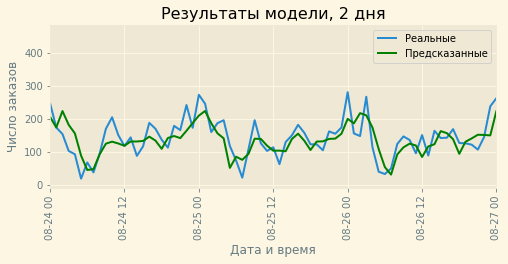

In [75]:
test_target = pd.DataFrame(test_target)
test_target['predict'] = predicted_test

In [76]:
test_target

,num_orders,predict
datetime,,
2018-08-13 14:00:00,102,106.76
2018-08-13 15:00:00,175,122.55
2018-08-13 16:00:00,144,142.63
2018-08-13 17:00:00,152,140.01
2018-08-13 18:00:00,104,85.87
...,...,...
2018-08-31 19:00:00,136,106.01
2018-08-31 20:00:00,154,107.26
2018-08-31 21:00:00,159,138.23


In [77]:
test_target = test_target['2018-08-29 23:00:00':'2018-08-31 23:00:00']

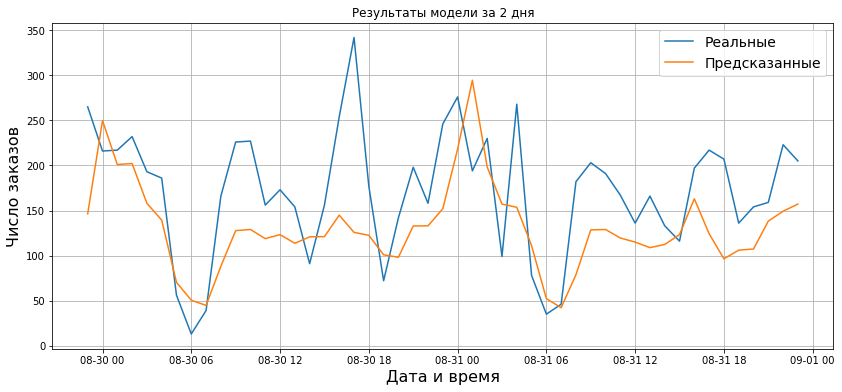

In [78]:
x = test_target.index
y_1 = test_target['num_orders']
y_2 = test_target['predict']
fig = plt.subplots(figsize=(14,6))
plt.plot(x,y_1, label='Реальные')
plt.plot(x,y_2, label='Предсказанные')
plt.legend(fontsize=14)
plt.ylabel('Число заказов', fontsize=16)
plt.xlabel('Дата и время', fontsize=16)
plt.title('Результаты модели за 2 дня')
plt.grid(which='major')
plt.show()
